In [1]:
%gui wx
import sys
import os


notebook_dir = os.path.abspath("")
parent_dir = os.path.abspath(os.path.join(notebook_dir, '..'))
sys.path.append(parent_dir)
sys.path.append('.')
from utils import loadFSL, FSLeyesServer, mkdir_no_exist, interactive_MCQ





import lmod
await lmod.purge(force=True)
await lmod.load('fsl/6.0.7.4')
await lmod.load('freesurfer/7.4.1')
await lmod.list()


loadFSL()


import fsl.wrappers
from fsl.wrappers import fslmaths

import mne_nirs
import nilearn
from nilearn.datasets import fetch_development_fmri

import mne
import mne_nirs
import dipy
from dipy.data import fetch_bundles_2_subjects, read_bundles_2_subjects
import xml.etree.ElementTree as ET
import os.path as op
import nibabel as nib
import glob

import ants

import openneuro
from mne.datasets import sample
from mne_bids import BIDSPath, read_raw_bids, print_dir_tree, make_report


import requests
import urllib.request
from tqdm import tqdm


from fsl.wrappers import fast, bet
from fsl.wrappers.misc import fslroi
from fsl.wrappers import flirt
from fsl.wrappers import mcflirt



import glob
import pandas as pd
import numpy as np
import json
import subprocess

Gtk-Message: 15:44:49.028: Failed to load module "canberra-gtk-module"


In [2]:
def get_json_from_file(fname):
    f = open(fname)
    data = json.load(f)
    f.close()
    return data
    

In [3]:
bids_root='data_mp1' #create a folder manually
dataset_id = 'ds000171'
subject = '01'

import matplotlib.pyplot as plt

deriv_root = op.join(bids_root, 'derivatives')
preproc_root = op.join(bids_root, 'derivatives','preprocessed_data')
anat_path = op.join(bids_root, 'sub-control01', 'anat')

In [ ]:
#subprocess.run(["openneuro-py", "download", "--dataset", dataset_id, "--target-dir", bids_root, "--include", 'sub-control{}'.format(subject)], check=True)

In [6]:
otherfiles_list = [
    
    'dataset_description.json',
    'T1w.json',
    
    'task-music_bold.json',
   
]


def mkdir_no_exist(path):
    if not op.isdir(path):
        os.makedirs(path)
        
class DownloadProgressBar(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)

def download_url(url, output_path):
    with DownloadProgressBar(unit='B', unit_scale=True,
                             miniters=1, desc=url.split('/')[-1]) as t:
        urllib.request.urlretrieve(url, filename=output_path, reporthook=t.update_to)


for filename in otherfiles_list:
    # Construct the download link for these files
    download_link = f'https://openneuro.org/crn/datasets/{dataset_id}/snapshots/00001/files/{filename}'
    print(f'Attempting download from: {download_link}')
    # Download the file without specifying file_type
    download_url(download_link, op.join(bids_root, 'sub-control01', 'func', filename))
    print('Downloaded:', filename)

Attempting download from: https://openneuro.org/crn/datasets/ds000171/snapshots/00001/files/dataset_description.json


dataset_description.json: 8.19kB [00:00, 14.7kB/s]


Downloaded: dataset_description.json
Attempting download from: https://openneuro.org/crn/datasets/ds000171/snapshots/00001/files/T1w.json


T1w.json: 8.19kB [00:00, 15.5kB/s]


Downloaded: T1w.json
Attempting download from: https://openneuro.org/crn/datasets/ds000171/snapshots/00001/files/task-music_bold.json


task-music_bold.json: 8.19kB [00:00, 15.2kB/s]

Downloaded: task-music_bold.json


In [17]:
fsleyesDisplay = FSLeyesServer()

In [23]:
from nilearn.image import concat_imgs

# Define the paths to your gzipped NIfTI files
file_paths = [
    'sub-control01_task-music_run-1_bold.nii.gz',
    'sub-control01_task-music_run-2_bold.nii.gz',
    'sub-control01_task-music_run-3_bold.nii.gz'

]

def standardize(img):
    data = img.get_fdata()
    mean = np.mean(data)
    std = np.std(data)
    standardized_data = (data - mean) / std
    return nib.Nifti1Image(standardized_data, img.affine)

# Initialize a list to hold standardized data
standardized_data_list = []

# Process each file
for file_path in file_paths:
    img = nib.load(os.path.join(bids_root, 'sub-control01', 'func', file_path))
    
    standardized_data = standardize(img)
    standardized_data_list.append(standardized_data)


concatenated_img = concat_imgs(standardized_data_list)


# Save the concatenated image as a gzipped NIfTI file
#nib.save(concatenated_img, os.path.join(bids_root, 'sub-control01', 'func', 'sub-control01_task-music_concatenated_bold.nii.gz'))

In [24]:
#mkdir_no_exist(bids_root)
mkdir_no_exist(deriv_root)
mkdir_no_exist(preproc_root)
mkdir_no_exist(os.path.join(preproc_root, 'sub-control01'))
mkdir_no_exist(os.path.join(preproc_root, 'sub-control01', 'func'))

path_original_data = os.path.join(bids_root, 'sub-control01', 'func', 'sub-control01_task-music_concatenated_bold')
path_moco_data = os.path.join(preproc_root, 'sub-control01', 'func', 'sub-control01_task-music_concatenated_bold_moco')
#mcflirt(infile=path_original_data,o=path_moco_data, plots=True, report=True, dof=6, mats=True)

Processed data will be saved as data_mp1/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-music_concatenated_bold_moco

McFLIRT v 2.0 - FMRI motion correction

Reading time series... 
first iteration - 8mm scaling, set tolerance
Rescaling reference volume [157] to 8 mm pixels
Registering volumes ... [158][159][160][161][162][163][164][165][166][167][168][169][170][171][172][173][174][175][176][177][178][179][180][181][182][183][184][185][186][187][188][189][190][191][192][193][194][195][196][197][198][199][200][201][202][203][204][205][206][207][208][209][210][211][212][213][214][215][216][217][218][219][220][221][222][223][224][225][226][227][228][229][230][231][232][233][234][235][236][237][238][239][240][241][242][243][244][245][246][247][248][249][250][251][252][253][254][255][256][257][258][259][260][261][262][263][264][265][266][267][268][269][270][271][272][273][274][275][276][277][278][279][280][281][282][283][284][285][286][287][288][289][290][291][292][293]

refnum = 157
Original_refvol = -1


Registering volumes ... [158][159][160][161][162][163][164][165][166][167][168][169][170][171][172][173][174][175][176][177][178][179][180][181][182][183][184][185][186][187][188][189][190][191][192][193][194][195][196][197][198][199][200][201][202][203][204][205][206][207][208][209][210][211][212][213][214][215][216][217][218][219][220][221][222][223][224][225][226][227][228][229][230][231][232][233][234][235][236][237][238][239][240][241][242][243][244][245][246][247][248][249][250][251][252][253][254][255][256][257][258][259][260][261][262][263][264][265][266][267][268][269][270][271][272][273][274][275][276][277][278][279][280][281][282][283][284][285][286][287][288][289][290][291][292][293][294][295][296][297][298][299][300][301][302][303][304][305][306][307][308][309][310][311][312][313][314][156][155][154][153][152][151][150][149][148][147][146][145][144][143][142][141][140][139][138][137][136][135][134][133][132][131][130][129][128][127][126][125][124][123][122][121][120][119][

{}

In [ ]:
fsleyesDisplay.show()
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(path_original_data)
fsleyesDisplay.load(path_moco_data)

In [13]:
def load_mot_params_fsl_6_dof(path):
    return pd.read_csv(path, sep='  ', header=None, 
            engine='python', names=['Rotation x', 'Rotation y', 'Rotation z','Translation x', 'Translation y', 'Translation z'])

mot_params = load_mot_params_fsl_6_dof(op.join(preproc_root, 'sub-control01', 'func', 'sub-control01_task-music_concatenated_bold_moco.par'))
mot_params

,Rotation x,Rotation y,Rotation z,Translation x,Translation y,Translation z
0,-0.003267,0.002930,5.552720e-07,-0.059817,-0.518985,-0.470659
1,-0.003333,0.002930,-1.600820e-04,-0.066681,-0.490942,-0.467984
2,-0.003147,0.002880,-1.880300e-04,-0.053630,-0.470922,-0.446214
3,-0.003264,0.003291,-3.337180e-04,-0.067658,-0.483699,-0.463707
4,-0.002729,0.003120,-3.183150e-04,-0.073350,-0.470581,-0.494909
...,...,...,...,...,...,...
310,0.008946,-0.000008,-2.131270e-03,-0.087116,0.400872,0.237711
311,0.009100,-0.000159,-2.114960e-03,-0.084539,0.374362,0.217879
312,0.009154,-0.000425,-1.901570e-03,-0.085075,0.404540,0.224777
313,0.008975,-0.000425,-2.162820e-03,-0.103438,0.370850,0.211481


In [14]:
def compute_FD_power(mot_params):
    framewise_diff = mot_params.diff().iloc[1:]

    rot_params = framewise_diff[['Rotation x', 'Rotation y', 'Rotation z']]
    # Estimating displacement on a 50mm radius sphere
    # To know this one, we can remember the definition of the radian!
    # Indeed, let the radian be theta, the arc length be s and the radius be r.
    # Then theta = s / r
    # We want to determine here s, for a sphere of 50mm radius and knowing theta. Easy enough!
    
    # Another way to think about it is through the line integral along the circle.
    # Integrating from 0 to theta with radius 50 will give you, unsurprisingly, r0 theta.
    converted_rots = rot_params*50
    trans_params = framewise_diff[['Translation x', 'Translation y', 'Translation z']]
    fd = converted_rots.abs().sum(axis=1) + trans_params.abs().sum(axis=1)
    return fd

fd = compute_FD_power(mot_params).to_numpy()

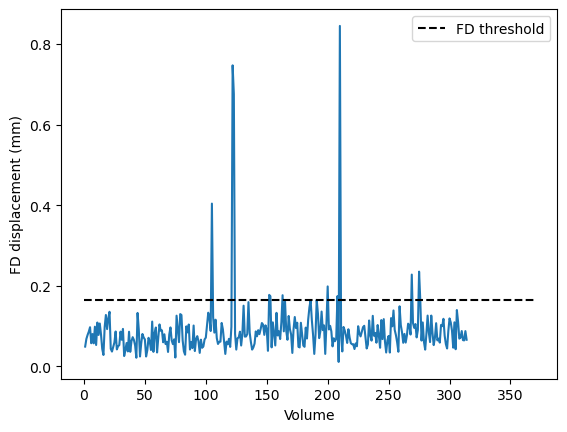

In [15]:
#%matplotlib inline
threshold = np.quantile(fd,0.75) + 1.5*(np.quantile(fd,0.75) - np.quantile(fd,0.25))
plt.plot(list(range(1, fd.size+1)), fd)
plt.xlabel('Volume')
plt.ylabel('FD displacement (mm)')
plt.hlines(threshold, 0, 370,colors='black', linestyles='dashed', label='FD threshold')
plt.legend()
plt.show()

In [16]:
np.where(fd > threshold)[0] + 1

array([105, 122, 123, 152, 153, 163, 186, 191, 200, 208, 210, 269, 275])

SLICE TIMING CORRECTION


In [115]:
data = get_json_from_file(op.join(bids_root, 'sub-control01', 'func', 'task-music_bold.json'))
print(data)
slice_timing = data['SliceTiming'] # Replace with the appropriate key (have a look above!)
tr = data['RepetitionTime'] # Extract the TR from the sidecar's appropriate field


{'TaskName': 'Music', 'RepetitionTime': 3.0, 'EchoTime': 0.025, 'FlipAngle': 90.0, 'SequenceName': 'EPI BOLD', 'Manufacturer': 'Siemens', 'ManufacturersModelName': 'Skyra', 'MagneticFieldStrength': 3.0, 'ParallelImagingReductionFactor': 0, 'SliceTimingComputationMethod': '(slicenum*RepetitionTime/TotalSlices), interleaved according to Siemens even-numbered slice convention (even slices first).', 'SliceTiming': [1.5, 0.0, 1.56, 0.06, 1.62, 0.12, 1.68, 0.18, 1.74, 0.24, 1.8, 0.3, 1.86, 0.36, 1.92, 0.42, 1.98, 0.48, 2.04, 0.54, 2.1, 0.6, 2.16, 0.66, 2.22, 0.72, 2.28, 0.78, 2.34, 0.84, 2.4, 0.9, 2.46, 0.96, 2.52, 1.02, 2.58, 1.08, 2.64, 1.14, 2.7, 1.2, 2.76, 1.26, 2.82, 1.32, 2.88, 1.38, 2.94, 1.44]}


In [118]:
slice_order = np.argsort(slice_timing) + 1
print(slice_order)
# Write to a file the corresponding sorted timings :)
timing_path = op.join(preproc_root,  'sub-control01', 'func', 'sub-control01_task-sitrep_run-01_slice-timings.txt')
file = open(timing_path, mode='w')
for t in slice_order:

    file.write(str(t) + '\n')
file.close()

[ 2  4  6  8 10 12 14 16 18 20 22 24 26 28 30 32 34 36 38 40 42 44 46 48
 50  1  3  5  7  9 11 13 15 17 19 21 23 25 27 29 31 33 35 37 39 41 43 45
 47 49]


In [119]:
file_to_realign = op.join(preproc_root, 'sub-control01', 'func', 'sub-control01_task-music_concatenated_bold_moco.nii.gz')
output_target = op.join(preproc_root, 'sub-control01', 'func', 'sub-control01_task-music_concatenated_bold_slice-corr.nii.gz')

subprocess.run(['slicetimer', '-i', file_to_realign, '-o', output_target, '-d', str(3), '--ocustom={}'.format(timing_path)])
#cmd = 'slicetimer -i ' + file_to_realign + ' -o ' + output_target + ' -r ' + str(tr) + ' -d 3 --ocustom=' + timing_path
#os.system(cmd)

CompletedProcess(args=['slicetimer', '-i', 'data_mp1/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-music_concatenated_bold_moco.nii.gz', '-o', 'data_mp1/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-music_concatenated_bold_slice-corr.nii.gz', '-d', '3', '--ocustom=data_mp1/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-sitrep_run-01_slice-timings.txt'], returncode=0)

In [52]:
output_path = op.join(preproc_root, 'sub-control01', 'func', 'sub-control01_task-music_concatenated_bold_slice-corr.nii.gz')

#cmd = 'fslmaths {} -s {} {}_smoothed-6mm'.format(output_path, 6/2.3548, output_path)
subprocess.run(['fslmaths',output_path, '-s', str(6/2.3548), '{}_smoothed-6mm'.format(output_path)])

CompletedProcess(args=['fslmaths', 'data_mp1/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-music_concatenated_bold_slice-corr.nii.gz', '-s', '2.547987090198743', 'data_mp1/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-music_concatenated_bold_slice-corr.nii.gz_smoothed-6mm'], returncode=0)

In [26]:
fsleyesDisplay.show()
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(output_path + '_smoothed-6mm')

In [7]:

func_path = op.join(bids_root, 'sub-control01', 'func')



evt1=pd.read_csv(op.join(func_path, 'sub-control01_task-music_run-1_events.tsv'), sep='\t')
evt2=pd.read_csv(op.join(func_path, 'sub-control01_task-music_run-2_events.tsv'), sep='\t')
evt3=pd.read_csv(op.join(func_path, 'sub-control01_task-music_run-3_events.tsv'), sep='\t')


evt_concat=pd.concat([evt1,evt2,evt3], ignore_index=True)
evt_concat['onset']=evt_concat['duration'].cumsum()
evt_concat

,onset,duration,trial_type
0,33.0,33.0,tones
1,36.0,3.0,response
2,67.5,31.5,negative_music
3,70.5,3.0,response
4,102.0,31.5,tones
5,105.0,3.0,response
6,136.5,31.5,positive_music
7,139.5,3.0,response
8,171.0,31.5,tones
9,174.0,3.0,response


In [19]:
import numpy as np

# Set parameters
TR = 3  # Repetition time (in seconds)
total_time = 936  # Total time of the scan in seconds
time_points = np.arange(0, total_time, TR)


In [20]:
from nilearn.glm.first_level import make_first_level_design_matrix

# Generate design matrix using Nilearn's HRF
design_matrix = make_first_level_design_matrix(
    frame_times=time_points,
    events=evt_concat,
    hrf_model='spm',
    drift_model='polynomial'
)

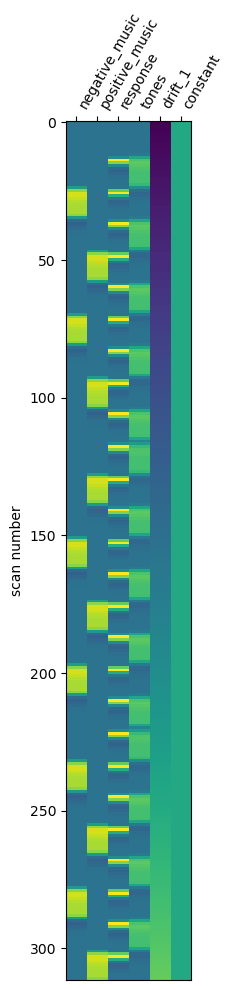

In [21]:
from nilearn.plotting import plot_design_matrix
plot_design_matrix(design_matrix)
plt.show()

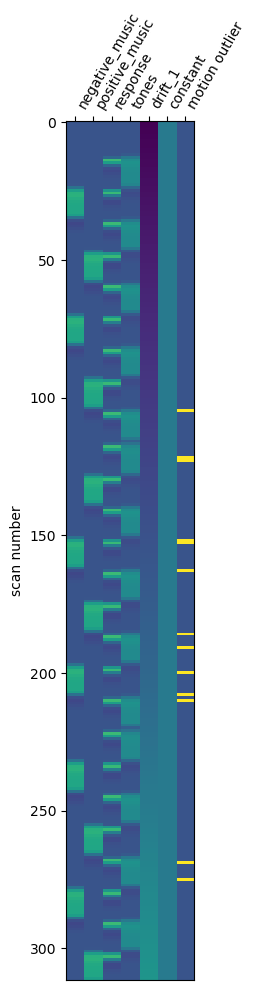

In [23]:
reg = np.zeros((312))
reg[np.where(fd > threshold)[0] + 1] = 1


design_mat_regged = design_matrix.copy()
design_mat_regged['motion outlier'] = reg

plot_design_matrix(design_mat_regged)
plt.show()

In [120]:
fmri_img = op.join(preproc_root, 'sub-control01', 'func', 'sub-control01_task-music_concatenated_bold_slice-corr.nii.gz')

In [27]:
from nilearn.glm.first_level import make_first_level_design_matrix, FirstLevelModel

# Specify what sort of GLM we want (nature of the noise, repetition time of the data and other parameters)
fmri_glm = FirstLevelModel(t_r=3,
                           noise_model='ar1',
                           standardize=False,
                           hrf_model='spm',
                           drift_model=None,
                           high_pass=.01)

# Fit the model to our design and data
fmri_glm = fmri_glm.fit(fmri_img, evt_concat)

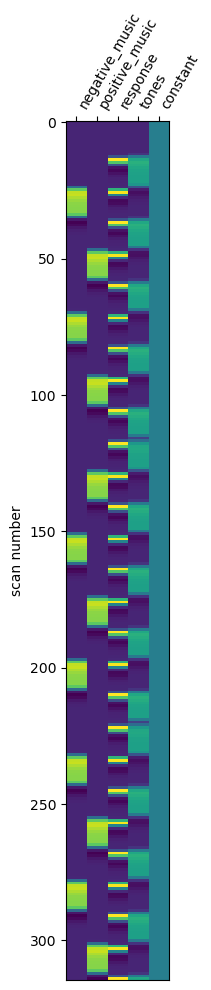

In [28]:
from nilearn.plotting import plot_design_matrix
plot_design_matrix(fmri_glm.design_matrices_[0])
plt.show()

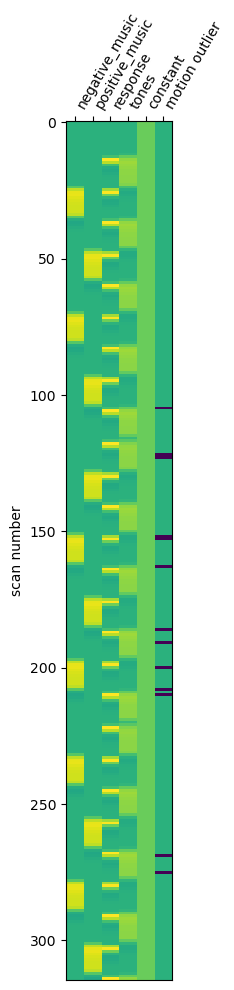

In [63]:
reg = np.zeros((315))
reg[np.where(fd > threshold)[0] + 1] = -1

design_matrix=fmri_glm.design_matrices_[0]
design_mat_regged = design_matrix.copy()
design_mat_regged['motion outlier'] = reg

plot_design_matrix(design_mat_regged)
plt.show()

In [64]:
fmri_glm = fmri_glm.fit(fmri_img, design_matrices=[design_mat_regged])

In [65]:
conditions = {
    'active_neg': np.array([1, 0, 0,0,0]), # Specify the np array, e.g. np.array([2, -1, 0]) to extract active
    'active_pos':np.array([0, 1,0, 0,0]), # Specify the np array, e.g. np.array([2, -1, 0]) to extract rest
    'response':np.array([0, 0,1, 0,0]), # Specify the np array, e.g. np.array([2, -1, 0]) to extract rest
    'rest':np.array([0, 0, 0,1,0]) # Specify the np array, e.g. np.array([2, -1, 0]) to extract rest

}

active_minus_rest = conditions['active_pos'] - conditions['active_neg']
active_minus_rest=np.array([-1, 2, 0,0,0,0])

<Axes: label='conditions'>

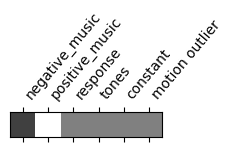

In [66]:
from nilearn.plotting import plot_contrast_matrix
plot_contrast_matrix(active_minus_rest, design_matrix=design_mat_regged)  ####TODO ADD COLOR SCALE

/opt/conda/lib/python3.11/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/opt/conda/lib/python3.11/site-packages/nilearn/plotting/html_document.py:102: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  warnings.warn(



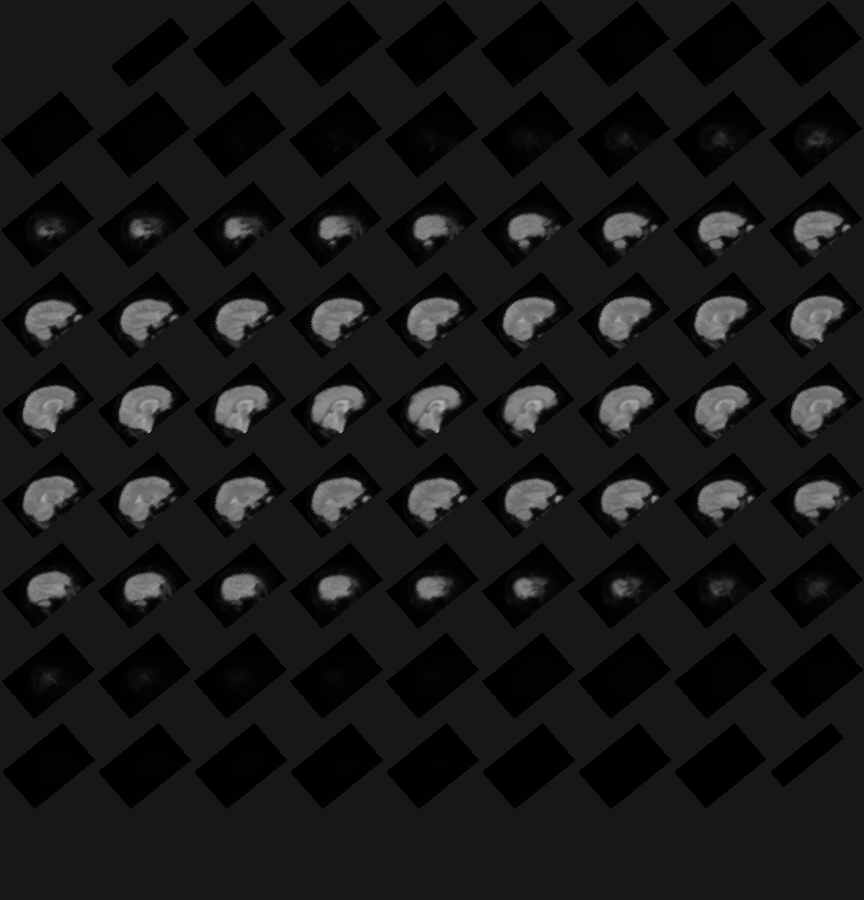
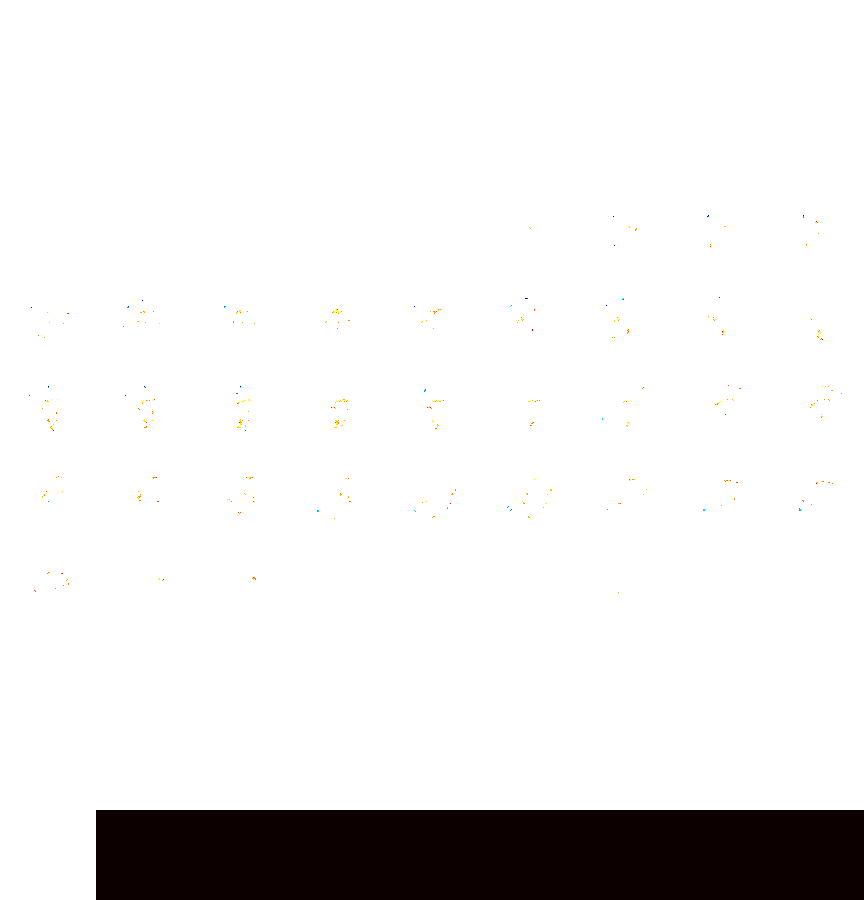

In [68]:
from nilearn.image import mean_img
from nilearn.plotting import view_img
import nibabel as nib

# Assuming fmri_glm and active_minus_rest are defined elsewhere in your code
z_map = fmri_glm.compute_contrast(active_minus_rest, output_type='z_score')

# Save the Z map to a file
nib.save(z_map, 'z_map_uncorrected.nii.gz')

# Compute the mean image
mean_img_ = mean_img(fmri_img)

# Use view_img for 3D visualization
view = view_img(z_map, bg_img=mean_img_, threshold=2.0, title='Active minus Rest (Z>2)')

# Display the interactive view within the notebook
view



Added README.md to /home/jovyan/nilearn_data


Dataset created in /home/jovyan/nilearn_data/aal_SPM12



 ...done. (1 seconds, 0 min)
Extracting data from /home/jovyan/nilearn_data/aal_SPM12/a4f2a6316ec7f29f771edef840308edf/aal_for_SPM12.tar.gz..... done.
/opt/conda/lib/python3.11/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



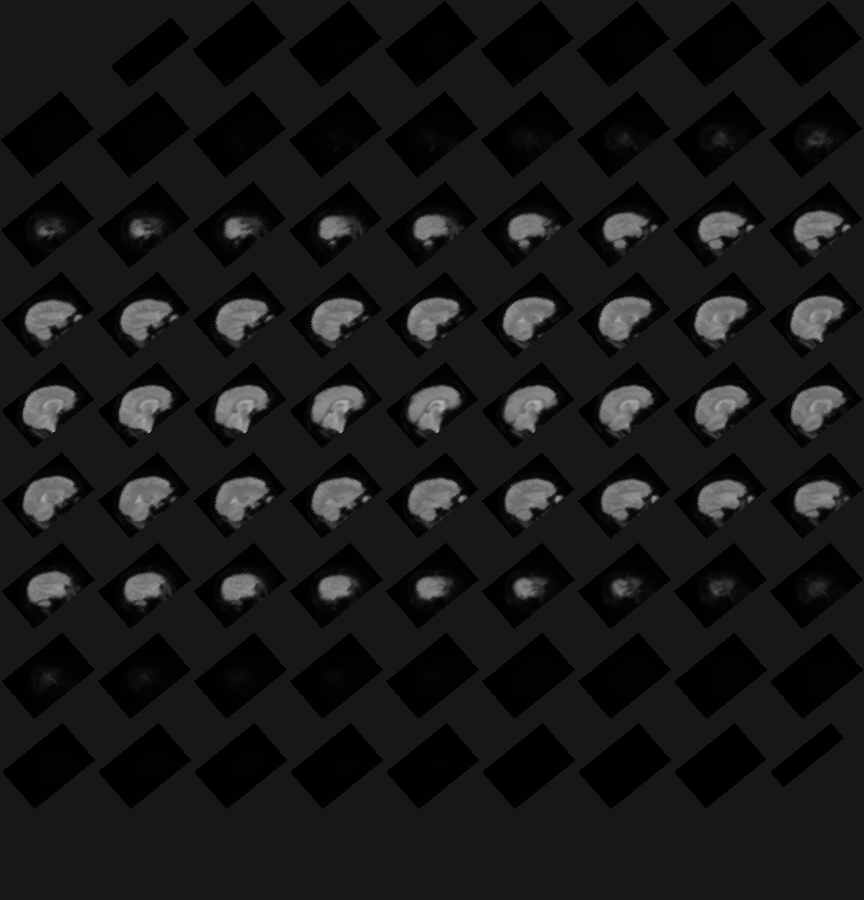
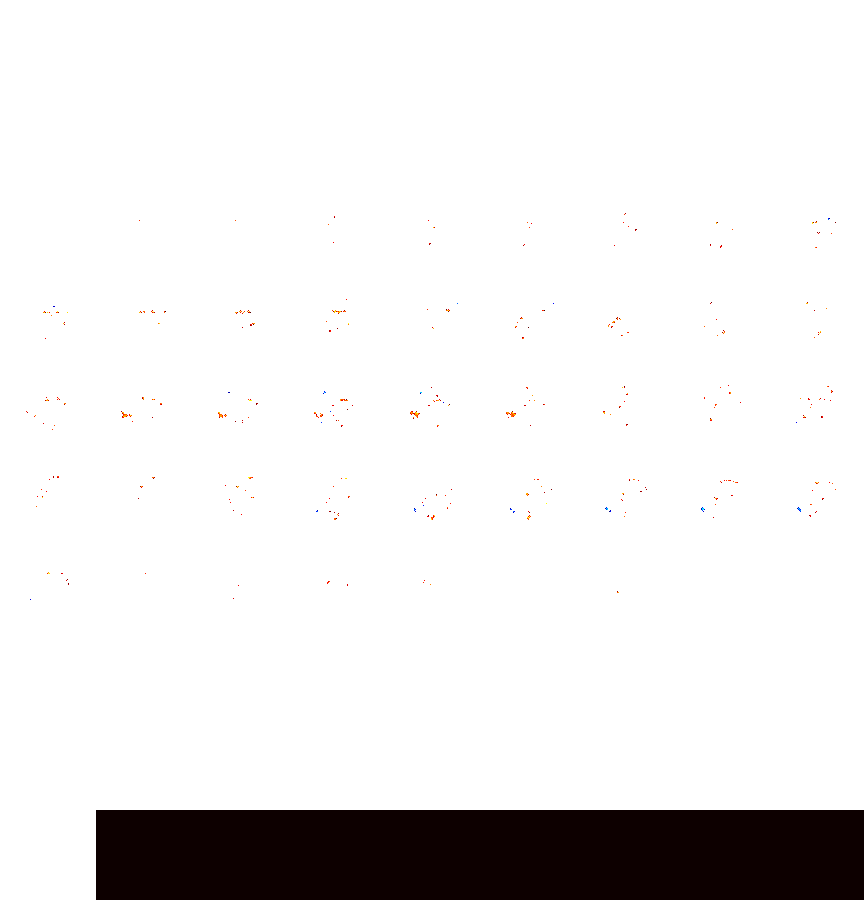

In [34]:
from nilearn import plotting, image, datasets
import nibabel as nib

# Assuming fmri_glm and active_minus_rest are defined elsewhere in your code
z_map = fmri_glm.compute_contrast(active_minus_rest, output_type='z_score')

# Save the Z map to a file
nib.save(z_map, 'z_map_uncorrected.nii.gz')

# Compute the mean image
mean_img_ = image.mean_img(fmri_img)

# Threshold the z-map to create a mask for significant areas
thresholded_z_map = image.threshold_img(z_map, threshold=1.5)

# Fetch the AAL atlas
aal_atlas = datasets.fetch_atlas_aal()

# Use view_img for 3D visualization
view = plotting.view_img(thresholded_z_map, bg_img=mean_img_, title='Highlighted Zones of Interest')


# Display the interactive view
view


/opt/conda/lib/python3.11/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/opt/conda/lib/python3.11/site-packages/nilearn/image/resampling.py:756: UserWarning: Casting data from int32 to float32
  return resample_img(



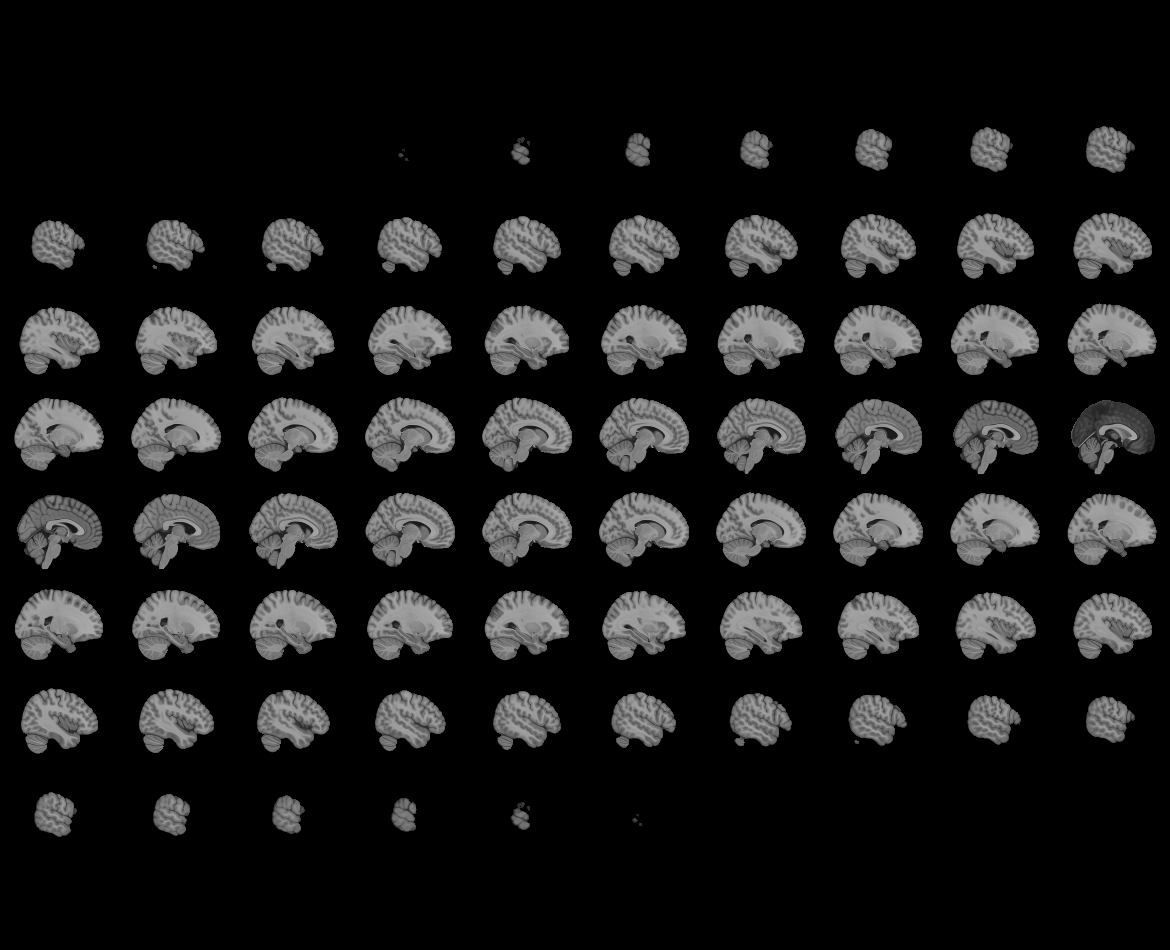
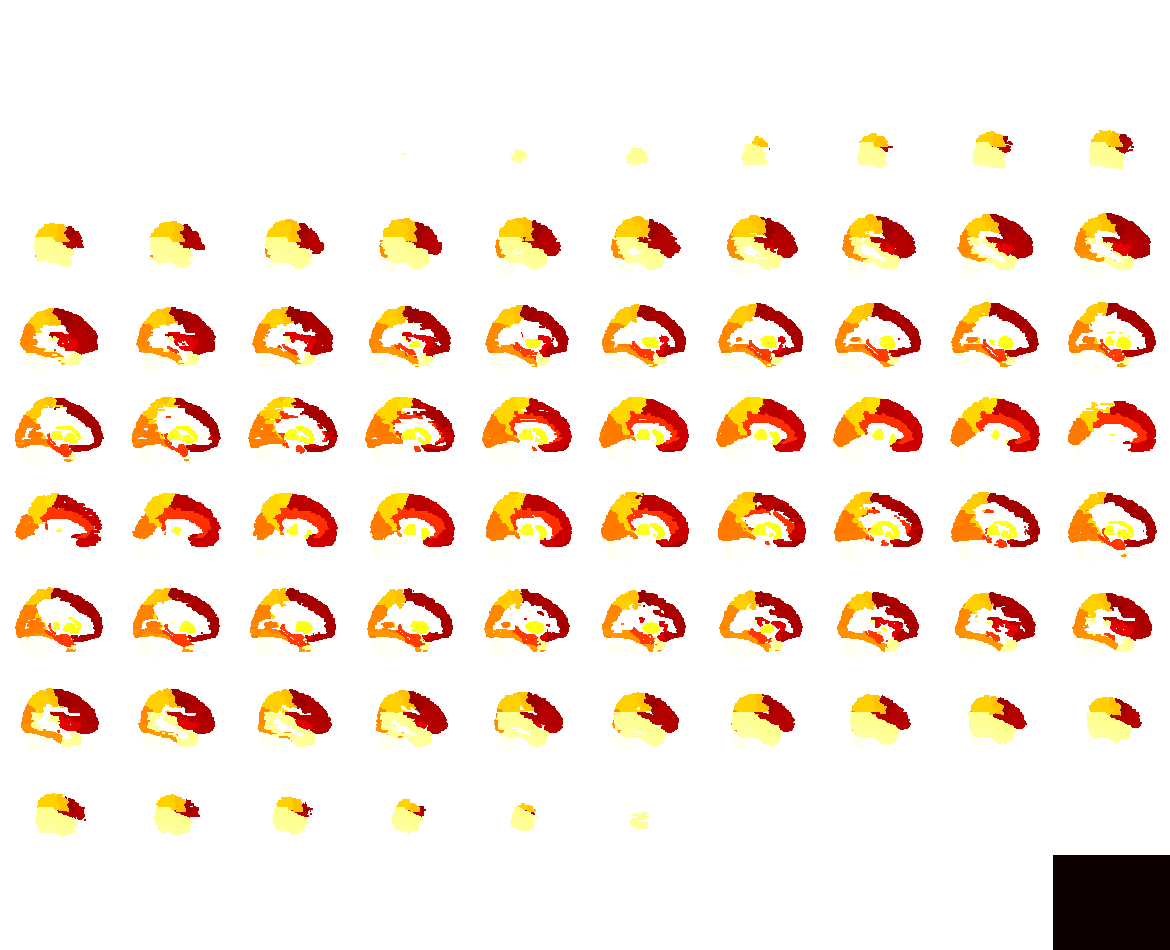

In [36]:
# Use view_img for 3D visualization
view = plotting.view_img(aal_atlas.maps)


# Display the interactive view
view


In [121]:
from scipy.stats import zscore
from sklearn.decomposition import FastICA, PCA

img = nib.load(fmri_img)
img_data = img.get_fdata()

affine = nib.load(fmri_img).affine
x,y,z,t = img_data.shape



X = img_data.reshape(img_data.shape[3], -1)


X=X.T-X.mean(axis=1)
print(X)
Z = zscore(X,axis=0) # across subjects
Z = np.nan_to_num(X,0) # nan to 0s
print("Z matrix size: ", Z.shape)
print(Z)

[[ 0.0005961  -0.00065332 -0.00126584 ...  0.00544597 -0.00117249
  -0.00211975]
 [ 0.0005961  -0.00081544 -0.00112994 ...  0.00364001  0.01267281
   0.00018754]
 [ 0.0005961  -0.00078379 -0.00119473 ... -0.00056099  0.00884214
   0.00563773]
 ...
 [-0.00062389 -0.00084376 -0.00065561 ...  0.01683695 -0.00136429
  -0.01745788]
 [-0.00080944 -0.00088423 -0.00065632 ... -0.00263958  0.00131064
  -0.02153459]
 [-0.00061    -0.0005806  -0.00074299 ...  0.01506574 -0.0059467
  -0.01317278]]
Z matrix size:  (320000, 315)
[[ 0.0005961  -0.00065332 -0.00126584 ...  0.00544597 -0.00117249
  -0.00211975]
 [ 0.0005961  -0.00081544 -0.00112994 ...  0.00364001  0.01267281
   0.00018754]
 [ 0.0005961  -0.00078379 -0.00119473 ... -0.00056099  0.00884214
   0.00563773]
 ...
 [-0.00062389 -0.00084376 -0.00065561 ...  0.01683695 -0.00136429
  -0.01745788]
 [-0.00080944 -0.00088423 -0.00065632 ... -0.00263958  0.00131064
  -0.02153459]
 [-0.00061    -0.0005806  -0.00074299 ...  0.01506574 -0.0059467
  -0

In [122]:
#* Run FastICA on X -- check 

S_dict = {}

# assign the variable nb_components to be the list of components (try 3-5 values )

nb_components =  [15,]#10]#20, 60 ...]

## NOTE that 60 components can be computational costly

#* We will transpose the matrix X so that ICA algorithm operates on the voxels dimension.
#* In other words, the estimated sources (S) should be have dimensionality [#voxels]

for n in nb_components:
    print(f"Processing component {n}")
    # run PCA as a preprocessing step for ICA with twice the number of components
    n2=2*n
    ### YOUR CODE HERE
    pca = PCA(n_components=n2)
    H = pca.fit_transform(Z)  # Reconstruct signals based on orthogonal components
    
    # Reminder: Fast ICA model S = X W
    print("Running FastICA with n = %d components" %n)

    ica = FastICA(n_components=n, random_state=1, max_iter=5000)
    S_ = ica.fit_transform(H)  # Get the estimated sources (S)

    print(S_.shape)
    W_ = ica.components_ # Get the estimated un-mixing matrix (W) -- will not be used further on
    S_dict[n] = S_ # store the results in a dictionary

    print("Done")

Processing component 15
Running FastICA with n = 15 components
(320000, 15)
Done


In [18]:
def get_skull_stripped_anatomical(bids_root, preproc_root, subject_id, robust=False):
    """
    Perform skull-stripping on the T1w anatomical image for the specified subject.
        Parameters
    ----------
    bids_root: string
        The root of the BIDS directory
    preproc_root: string
        The root of the preprocessed data, where the result of the brain extraction will be saved.
    subject_id: string
        Subject ID, the subject on which brain extraction should be conducted.
    robust: bool
        Whether to conduct robust center estimation with BET or not. Default is False.
    """
    subject = f'sub-{subject_id}'
    anatomical_path = op.join(bids_root, subject, 'anat', f'{subject}_T1w.nii.gz')
    
    betted_brain_path = op.join(preproc_root, subject, 'anat', f'{subject}_T1w')

    mkdir_no_exist(op.join(preproc_root, subject, 'anat'))
    
    os.system(f'bet {anatomical_path} {betted_brain_path} -m {"-R" if robust else ""}')
    print("Done with BET.")

resulting_mask_path = op.join(preproc_root, 'sub-control01', 'anat', 'sub-control01_T1w_mask')

def apply_fsl_math_approach(img_path, mask_path, masked_img_path):
    """
    Parameters
    ----------
    img_path: str
        Path to the input image that needs to be masked.
    mask_path: str
        Path to the mask image.
    masked_img_path: str
        Path where the masked output image will be saved.
    """
    # Execute the fslmaths command with the -mas option
    os.system('fslmaths {} -mas {} {}'.format(img_path, mask_path, masked_img_path))
    print(f"Masked image saved at: {masked_img_path}")

# Define paths based on your dataset structure
subject_id = "control01"
anatomical_path = op.join(bids_root, f'sub-{subject_id}', 'anat', f'sub-{subject_id}_T1w.nii.gz')  # Original brain
betted_brain_path = op.join(preproc_root, f'sub-{subject_id}', 'anat', f'sub-{subject_id}_T1w.nii.gz')  # Skull-stripped brain
resulting_mask_path = op.join(preproc_root, f'sub-{subject_id}', 'anat', f'sub-{subject_id}_T1w_mask.nii.gz')  # The mask

apply_fsl_math_approach(betted_brain_path, resulting_mask_path, anatomical_path)



Masked image saved at: data_mp1/sub-control01/anat/sub-control01_T1w.nii.gz


In [19]:
T1w_img = nib.load(op.join(bids_root, 'sub-control01','anat','sub-control01_T1w.nii.gz'))

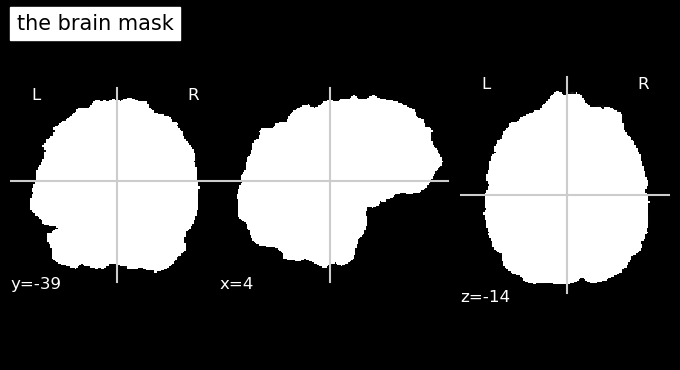

In [20]:
from nilearn import datasets
from nilearn.input_data import NiftiMasker
from nilearn.plotting import plot_stat_map, show
from nilearn.image import resample_to_img


#* Build brain mask to restrict analysis within the brain
icbms = datasets.fetch_icbm152_2009()
#mask_img = icbms.mask
mask_img = resulting_mask_path
#mask_img = resample_to_img(mask_img, fmri_img, interpolation='nearest')
masker = NiftiMasker(mask_img=mask_img)
masker.fit() # modification
plot_stat_map(mask_img, bg_img =T1w_img, black_bg=True, title='the brain mask', colorbar=False,)

Number of components:  15


/opt/conda/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:110: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


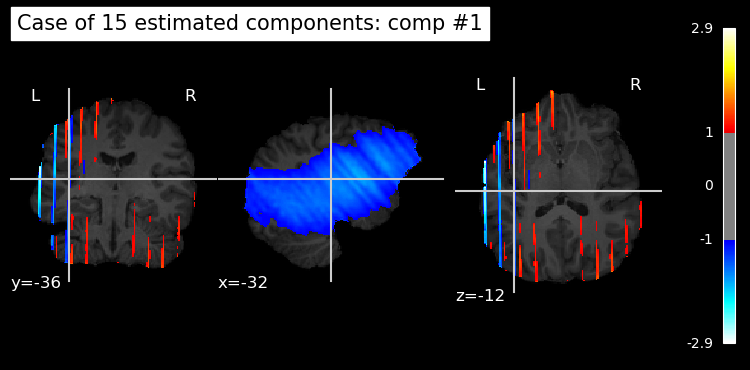

/opt/conda/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:110: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


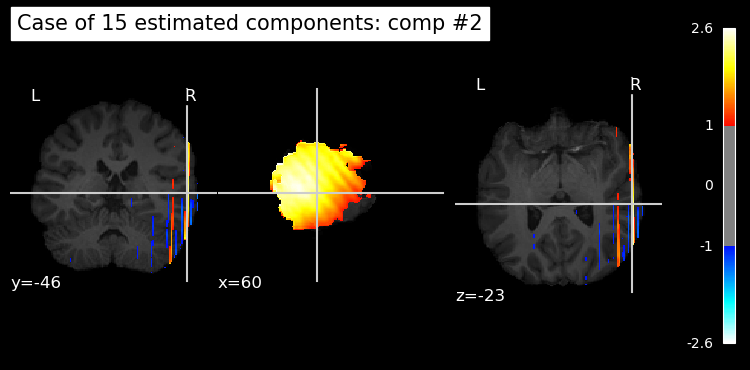

/opt/conda/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:110: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


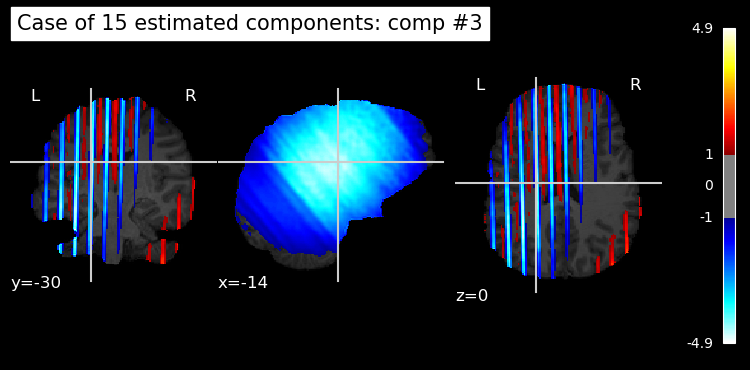

/opt/conda/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:110: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


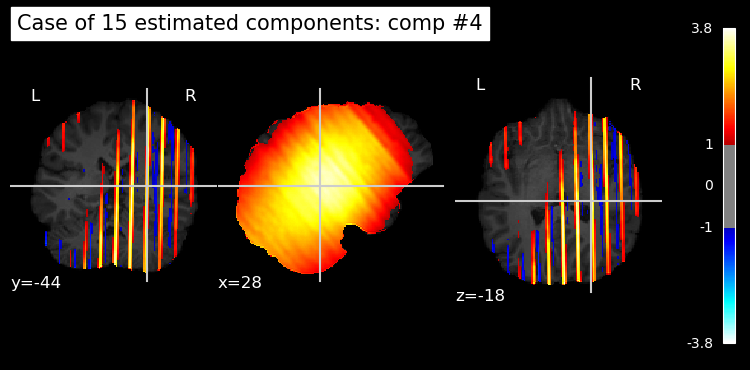

/opt/conda/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:110: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


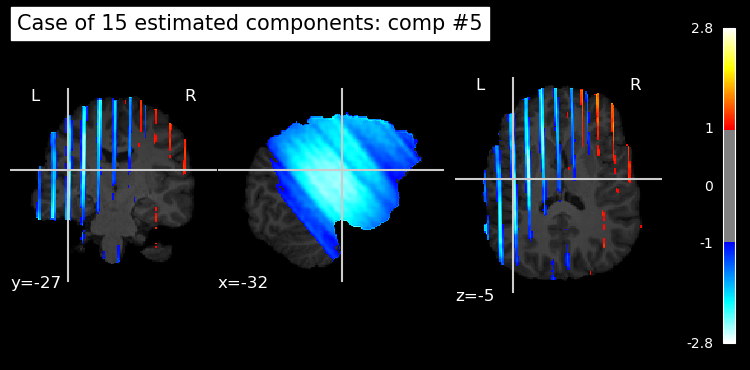

/opt/conda/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:110: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


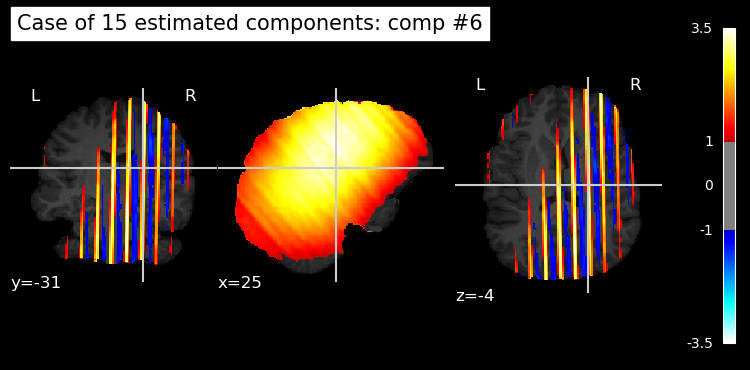

/opt/conda/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:110: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


KeyboardInterrupt: 

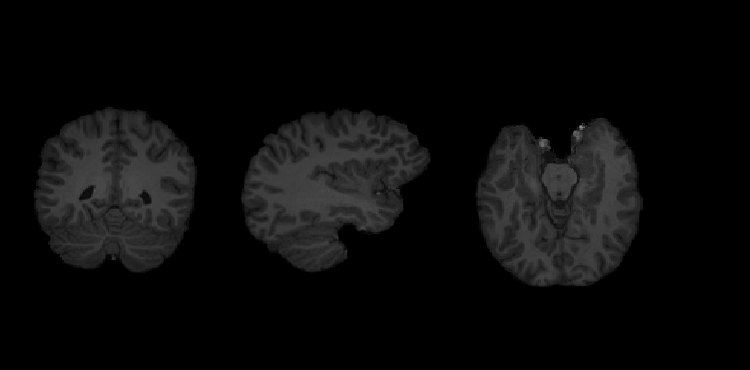

In [123]:


for n in nb_components:
    print('Number of components: ',n)
    S_ = S_dict[n].copy()
    for idx, s in enumerate(S_.T[:min(10, S_.T.shape[0]),:]): # plot min(4, #comp_estimated) components
        s_img = nib.Nifti1Image(np.reshape(s, (x,y,z)), affine)
        data = masker.fit_transform(s_img)
        masked_ = masker.inverse_transform(data) # mask the components
        plot_stat_map(masked_, display_mode="ortho", title='Case of {} estimated components: comp #{}'.format(n,idx+1),
                      colorbar=True, black_bg=True, threshold=1*np.std(s), bg_img=T1w_img,)
                      #output_file=save_results + "ICA_components_{}_n_{}.png".format(idx,n)) # uncomment to save plot
        plt.show()

